<h1>Predict Student Performance from Game Play</h1>

# Sommaire :

**Part 1: Notebook configuration**

 - <a href="#C11">P1.1 : Librairies loading </a>
 - <a href="#C12">P1.2 : Fonctions </a>
 - <a href="#C13">P1.3 : Data loading </a>
 
**Part 2: Data Analysis**
 
 - <a href="#C21">P2.1 : Data reducing </a>
 - <a href="#C22">P2.2 : Data preprocessing </a>
 - <a href="#C23">P2.3 : Target description </a>
 
**Part 3: Data modelling**

 - <a href="#C31">P3.1 : Logistic Regression </a>
 - <a href="#C32">P3.2 : Random Forest </a>
 - <a href="#C33">P3.3 : XGBoost </a>
 - <a href="#C34">P3.4 : Keras </a>
 - <a href="#C35">P3.5 :  Final model (optimization) </a>
 
**Part 4: Submission**
 
 - <a href="#C41">P4.1 : Submission </a>


# Part1: Notebook configuration

# <a name="C11"> P1.1 : Librairies loading </a>

In [1]:
import os
import gc

import jo_wilder

import numpy as np
import pandas as pd

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, GroupKFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

from xgboost import XGBClassifier

from tensorflow import keras
import tensorflow as tf

import matplotlib.pyplot as plt
import seaborn as sns
from colorama import init as colorama_init
from colorama import Fore
from colorama import Style
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 400)

Libraries are loaded above

# <a name="C12"> P1.2 : Functions </a>

In [2]:
#Reduce Memory Usage
def reduce_memory_usage(df):
    '''
    This function is used to reduce the memory size by adapting the used data types
    param :
    df: Pandas DataFrame 
    '''
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype.name
        if ((col_type != 'datetime64[ns]') & (col_type != 'category')):
            if (col_type != 'object'):
                c_min = df[col].min()
                c_max = df[col].max()

                if str(col_type)[:3] == 'int':
                    if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                        df[col] = df[col].astype(np.int8)
                    elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                        df[col] = df[col].astype(np.int16)
                    elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                        df[col] = df[col].astype(np.int32)
                    elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                        df[col] = df[col].astype(np.int64)

                else:
                    if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                        df[col] = df[col].astype(np.float16)
                    elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                        df[col] = df[col].astype(np.float32)
                    else:
                        pass
            else:
                df[col] = df[col].astype('category')
    mem_usg = df.memory_usage().sum() / 1024**2 
    print("Memory usage became: ",mem_usg," MB")
    
    return df

the function "reduce_memory_usage" reduces the RAM memory size : 2Gb ==> 780 Mb. Here the original notebook : https://www.kaggle.com/code/mohammad2012191/reduce-memory-usage-2gb-780mb

In [3]:
def feature_engineer(train):
    '''
    This function preprocess the data "train" : nunique for categorical variables,
    and mean\std for numerical variables
    param:
    tarin : Pandas DataFrame
    '''
    dfs = []
    for c in CATS:
        tmp = train.groupby(['session_id','level_group'])[c].agg('nunique')
        tmp.name = tmp.name + '_nunique'
        dfs.append(tmp)
    for c in NUMS:
        tmp = train.groupby(['session_id','level_group'])[c].agg('mean')
        dfs.append(tmp)
    for c in NUMS:
        tmp = train.groupby(['session_id','level_group'])[c].agg('std')
        tmp.name = tmp.name + '_std'
        dfs.append(tmp)
    df = pd.concat(dfs,axis=1)
    df = df.fillna(-1)
    df = df.reset_index()
    df = df.set_index('session_id')
    return df

The function "feature_engineer" updates and preprocesses the initial data for medelling. Original notebook : https://www.kaggle.com/code/cdeotte/random-forest-baseline-0-664/notebook

# <a name="C13"> P1.3 : Data loading </a>

In [4]:
%%time
train_path = '/kaggle/input/predict-student-performance-from-game-play/train.csv'
train = pd.read_csv(train_path)
print( train.shape )
train.head()

(13174211, 20)
CPU times: user 30.4 s, sys: 5.72 s, total: 36.1 s
Wall time: 1min


,session_id,index,elapsed_time,event_name,name,level,page,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,hover_duration,text,fqid,room_fqid,text_fqid,fullscreen,hq,music,level_group
0,20090312431273200,0,0,cutscene_click,basic,0,NaN,-413.991405,-159.314686,380.0,494.0,NaN,undefined,intro,tunic.historicalsociety.closet,tunic.historicalsociety.closet.intro,NaN,NaN,NaN,0-4
1,20090312431273200,1,1323,person_click,basic,0,NaN,-413.991405,-159.314686,380.0,494.0,NaN,"Whatcha doing over there, Jo?",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,NaN,NaN,NaN,0-4
2,20090312431273200,2,831,person_click,basic,0,NaN,-413.991405,-159.314686,380.0,494.0,NaN,Just talking to Teddy.,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,NaN,NaN,NaN,0-4
3,20090312431273200,3,1147,person_click,basic,0,NaN,-413.991405,-159.314686,380.0,494.0,NaN,I gotta run to my meeting!,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,NaN,NaN,NaN,0-4
4,20090312431273200,4,1863,person_click,basic,0,NaN,-412.991405,-159.314686,381.0,494.0,NaN,"Can I come, Gramps?",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,NaN,NaN,NaN,0-4


Data is loaded

In [6]:
%%time
train_labels_path = '/kaggle/input/predict-student-performance-from-game-play/train_labels.csv'
targets = pd.read_csv(train_labels_path)
targets['session'] = targets.session_id.apply(lambda x: int(x.split('_')[0]) )
targets['q'] = targets.session_id.apply(lambda x: int(x.split('_')[-1][1:]) )
print( targets.shape )
targets.head()

(212022, 4)
CPU times: user 534 ms, sys: 17.8 ms, total: 551 ms
Wall time: 552 ms


,session_id,correct,session,q
0,20090312431273200_q1,1,20090312431273200,1
1,20090312433251036_q1,0,20090312433251036,1
2,20090314121766812_q1,1,20090314121766812,1
3,20090314363702160_q1,1,20090314363702160,1
4,20090314441803444_q1,1,20090314441803444,1


Targets data is loaded

# Part 2: Data analysis

# <a name="C21"> P2.1 : Data reducing </a>

In [7]:
train = reduce_memory_usage(train)

Memory usage of dataframe is 2010.23 MB
Memory usage became:  778.9939136505127  MB


In [8]:
targets = reduce_memory_usage(targets)

Memory usage of dataframe is 6.47 MB
Memory usage became:  12.511058807373047  MB


Data and targets RAM sizes are reduced

# <a name="C22"> P2.2 : Data preprocessing </a>

In [12]:
CATS = ['event_name', 'name','fqid', 'room_fqid', 'text_fqid']
NUMS = ['elapsed_time','level','page','room_coor_x', 'room_coor_y', 
        'screen_coor_x', 'screen_coor_y', 'hover_duration']

In [13]:
%%time
df = feature_engineer(train)
print( df.shape )
df.head()

(35337, 22)
CPU times: user 16.4 s, sys: 163 µs, total: 16.4 s
Wall time: 16.5 s


,level_group,event_name_nunique,name_nunique,fqid_nunique,room_fqid_nunique,text_fqid_nunique,elapsed_time,level,page,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,hover_duration,elapsed_time_std,level_std,page_std,room_coor_x_std,room_coor_y_std,screen_coor_x_std,screen_coor_y_std,hover_duration_std
session_id,,,,,,,,,,,,,,,,,,,,,,
20090312431273200,0-4,10,3,30,7,17,8.579356e+04,1.945455,-1.000000,7.687500,-71.43750,448.50,383.00,2389.500000,49246.539458,1.230975,-1.000000,399.272451,129.295749,214.871000,104.082743,3227.370757
20090312431273200,13-22,10,3,49,12,35,1.040601e+06,17.402381,-1.000000,-130.375000,-162.00000,442.50,379.25,899.925903,126666.129584,2.358652,-1.000000,622.081128,230.373785,240.280218,99.067861,1305.088265
20090312431273200,5-12,10,3,39,11,24,3.572052e+05,8.054054,-1.000000,14.304688,-57.28125,452.00,378.75,969.333313,80175.676658,2.096919,-1.000000,357.219911,137.409158,203.268560,120.255453,1316.408315
20090312433251036,0-4,11,4,22,6,11,9.763342e+04,1.870504,0.000000,-84.062500,-53.65625,358.25,370.75,1378.750000,67372.714092,1.232616,0.000000,445.973993,156.183163,252.554707,121.062929,2114.876406
20090312433251036,13-22,11,6,73,16,43,2.498852e+06,17.762529,5.101562,-30.750000,-142.87500,462.75,388.00,720.384949,777382.529186,1.825923,0.863075,529.564669,234.275228,259.288856,133.345693,1990.705518


Preprocessed Data is generated

# <a name="C23"> P2.3 : Target description </a>

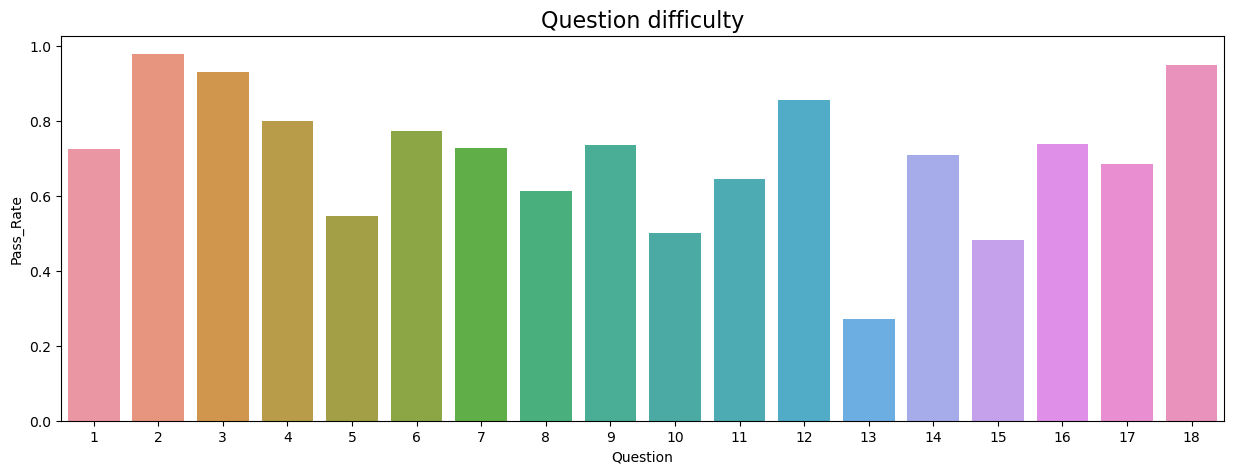

In [10]:
#Groupby questions
student_nb = targets['session'].nunique()
pass_rate = pd.DataFrame(targets.groupby('q').agg('correct').sum()/student_nb).reset_index()
pass_rate.columns = ['Question','Pass_Rate']

#Seaborn barplot
plt.rcParams['figure.figsize'] = (15,5)
sns.barplot(x="Question", y="Pass_Rate", data=pass_rate)
plt.title('Question difficulty', fontsize=16)
plt.show()

Questions pass_rate is given above

In [11]:
pass_rate = pass_rate.sort_values('Pass_Rate').reset_index(drop=True)
easiest_q = pass_rate.loc[17,'Question']
best_pass_rate = pass_rate.loc[17,'Pass_Rate']
hardest_q = pass_rate.loc[0,'Question']
worst_pass_rate = pass_rate.loc[0,'Pass_Rate']
mean_pass_rate = pass_rate['Pass_Rate'].mean()
print (f'Question {Fore.GREEN}{Style.BRIGHT}{easiest_q}{Style.RESET_ALL} is the easiest. {Fore.GREEN}{Style.BRIGHT}{best_pass_rate*100:.1f}%{Style.RESET_ALL} of the students got it right!')
print (f'Question {Fore.GREEN}{Style.BRIGHT}{hardest_q}{Style.RESET_ALL} is the hardest. Only {Fore.GREEN}{Style.BRIGHT}{worst_pass_rate*100:.1f}%{Style.RESET_ALL} of the students got it right!')
print (f'In average,{Fore.GREEN}{Style.BRIGHT}{mean_pass_rate*100:.1f}%{Style.RESET_ALL} of the answers are correct!')

Question 2 is the easiest. 97.9% of the students got it right!
Question 13 is the hardest. Only 27.0% of the students got it right!
In average,70.4% of the answers are correct!


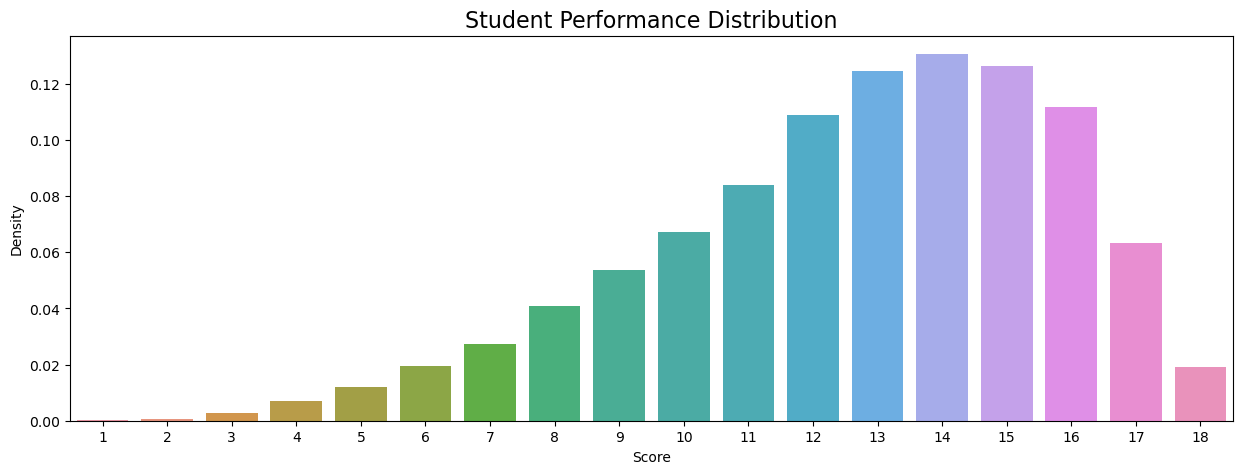

In [12]:
#Groupby Student (session)
student_performance = pd.DataFrame(targets.groupby('session').agg({'correct': 'sum'})).reset_index()
stud_perf_distrib = pd.DataFrame(student_performance.groupby('correct').agg({'session': 'count'})).reset_index()
stud_perf_distrib['session'] = stud_perf_distrib['session']/student_nb
stud_perf_distrib.columns = ['Score','Density']

#Seaborn barplot
sns.barplot(x="Score", y="Density", data=stud_perf_distrib)
plt.title('Student Performance Distribution', fontsize=16)
plt.show()

Score-Density distribution is given above

# Part 3: Data modelling

# <a name="C31"> P3.1 : Logistic Regression </a>

In [14]:
FEATURES = [c for c in df.columns if c != 'level_group']
print('We will train with', len(FEATURES) ,'features')
ALL_USERS = df.index.unique()
print('We will train with', len(ALL_USERS) ,'users info')

We will train with 21 features
We will train with 11779 users info


In [15]:
gkf = GroupKFold(n_splits=5)
oof = pd.DataFrame(data=np.zeros((len(ALL_USERS),18)), index=ALL_USERS)
LR_models = {}

# COMPUTE CV SCORE WITH 5 GROUP K FOLD
for i, (train_index, test_index) in enumerate(gkf.split(X=df, groups=df.index)):
    print('#'*25)
    print('### Fold',i+1)
    print('#'*25)
    
    # ITERATE THRU QUESTIONS 1 THRU 18
    for t in range(1,19):
        print(t,', ',end='')
        
        # USE THIS TRAIN DATA WITH THESE QUESTIONS
        if t<=3: grp = '0-4'
        elif t<=13: grp = '5-12'
        elif t<=22: grp = '13-22'
            
        # TRAIN DATA
        train_x = df.iloc[train_index]
        train_x = train_x.loc[train_x.level_group == grp]
        train_users = train_x.index.values
        train_y = targets.loc[targets.q==t].set_index('session').loc[train_users]
        
        # VALID DATA
        valid_x = df.iloc[test_index]
        valid_x = valid_x.loc[valid_x.level_group == grp]
        valid_users = valid_x.index.values
        valid_y = targets.loc[targets.q==t].set_index('session').loc[valid_users]
        
        # TRAIN MODEL
        clf = LogisticRegression(max_iter=500)
        clf.fit(train_x[FEATURES].astype('float32'), train_y['correct'])
        
        # SAVE MODEL, PREDICT VALID OOF
        LR_models[f'{grp}_{t}'] = clf
        oof.loc[valid_users, t-1] = clf.predict_proba(valid_x[FEATURES].astype('float32'))[:,1]
    print()

#########################
### Fold 1
#########################
1 , 2 , 3 , 4 , 5 , 6 , 7 , 8 , 9 , 10 , 11 , 12 , 13 , 14 , 15 , 16 , 17 , 18 , 
#########################
### Fold 2
#########################
1 , 2 , 3 , 4 , 5 , 6 , 7 , 8 , 9 , 10 , 11 , 12 , 13 , 14 , 15 , 16 , 17 , 18 , 
#########################
### Fold 3
#########################
1 , 2 , 3 , 4 , 5 , 6 , 7 , 8 , 9 , 10 , 11 , 12 , 13 , 14 , 15 , 16 , 17 , 18 , 
#########################
### Fold 4
#########################
1 , 2 , 3 , 4 , 5 , 6 , 7 , 8 , 9 , 10 , 11 , 12 , 13 , 14 , 15 , 16 , 17 , 18 , 
#########################
### Fold 5
#########################
1 , 2 , 3 , 4 , 5 , 6 , 7 , 8 , 9 , 10 , 11 , 12 , 13 , 14 , 15 , 16 , 17 , 18 , 


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [16]:
# PUT TRUE LABELS INTO DATAFRAME WITH 18 COLUMNS
true = oof.copy()
for k in range(18):
    # GET TRUE LABELS
    tmp = targets.loc[targets.q == k+1].set_index('session').loc[ALL_USERS]
    true[k] = tmp.correct.values

In [17]:
# FIND BEST THRESHOLD TO CONVERT PROBS INTO 1s AND 0s
scores = []; thresholds = []
LR_best_score = 0; LR_best_threshold = 0

for threshold in np.arange(0.4,0.81,0.01):
    print(f'{threshold:.02f}, ',end='')
    preds = (oof.values.reshape((-1))>threshold).astype('int')
    m = f1_score(true.values.reshape((-1)), preds, average='macro')   
    scores.append(m)
    thresholds.append(threshold)
    if m>LR_best_score:
        LR_best_score = m
        LR_best_threshold = threshold
        
print('\n' ,'Best_score:', LR_best_score, '\n','Best_threshold:', LR_best_threshold)

0.40, 0.41, 0.42, 0.43, 0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.50, 0.51, 0.52, 0.53, 0.54, 0.55, 0.56, 0.57, 0.58, 0.59, 0.60, 0.61, 0.62, 0.63, 0.64, 0.65, 0.66, 0.67, 0.68, 0.69, 0.70, 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77, 0.78, 0.79, 0.80, 
 Best_score: 0.6449027252404387 
 Best_threshold: 0.5800000000000002


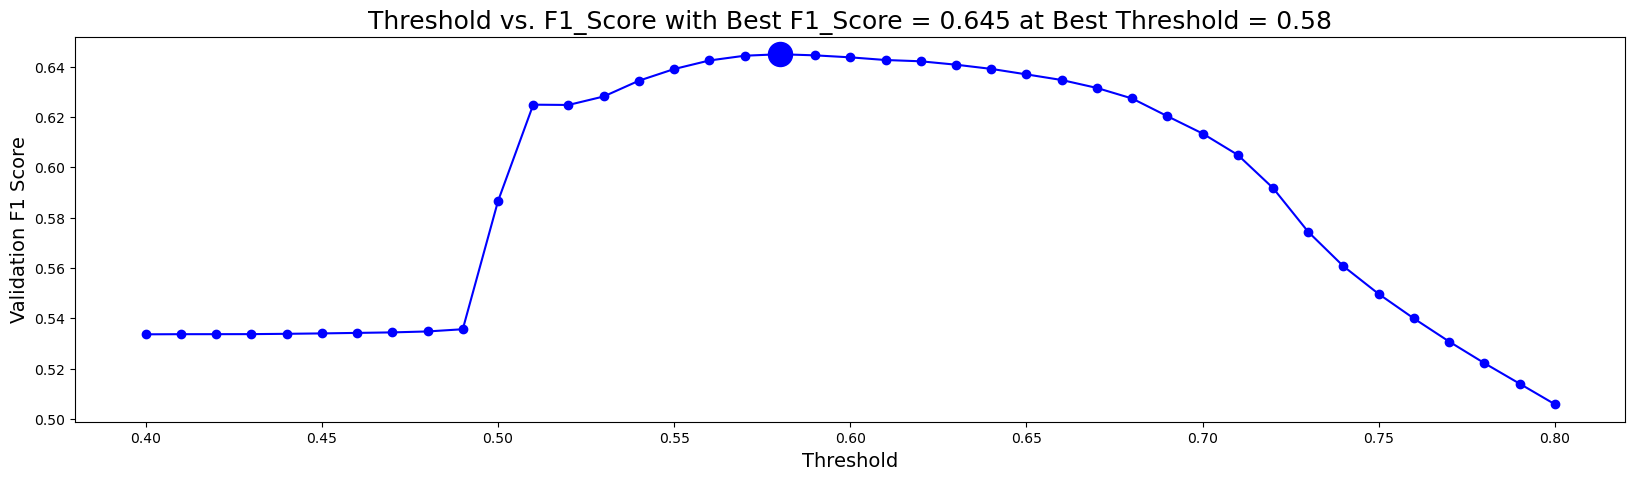

In [18]:
# PLOT THRESHOLD VS. F1_SCORE
plt.figure(figsize=(20,5))
plt.plot(thresholds,scores,'-o',color='blue')
plt.scatter([LR_best_threshold], [LR_best_score], color='blue', s=300, alpha=1)
plt.xlabel('Threshold',size=14)
plt.ylabel('Validation F1 Score',size=14)
plt.title(f'Threshold vs. F1_Score with Best F1_Score = {LR_best_score:.3f} at Best Threshold = {LR_best_threshold:.3}',size=18)
plt.show()

In [19]:
print('When using optimal threshold...')
for k in range(18):
        
    # COMPUTE F1 SCORE PER QUESTION
    m = f1_score(true[k].values, (oof[k].values>LR_best_threshold).astype('int'), average='macro')
    print(f'Q{k}: F1 =',m)
    
# COMPUTE F1 SCORE OVERALL
m = f1_score(true.values.reshape((-1)), (oof.values.reshape((-1))>LR_best_threshold).astype('int'), average='macro')
print('==> Overall F1 =',m)

When using optimal threshold...
Q0: F1 = 0.43818641712666323
Q1: F1 = 0.4945936668669012
Q2: F1 = 0.48369340144040407
Q3: F1 = 0.44713370530775287
Q4: F1 = 0.39627740566875513
Q5: F1 = 0.4600044919544549
Q6: F1 = 0.48254674889816274
Q7: F1 = 0.5123642855169477
Q8: F1 = 0.4591144250328278
Q9: F1 = 0.3345917456314343
Q10: F1 = 0.49028612414474126
Q11: F1 = 0.47801156230377184
Q12: F1 = 0.42238745408467254
Q13: F1 = 0.42109622844241085
Q14: F1 = 0.3408136997033969
Q15: F1 = 0.42975115734411545
Q16: F1 = 0.43401002108406345
Q17: F1 = 0.5031003295613617
==> Overall F1 = 0.6449027252404387


Logistic Regression model gets a F1_score = 0.645

# <a name="C32"> P3.2 : Random Forest </a>

This model is created by : https://www.kaggle.com/code/cdeotte/random-forest-baseline-0-664/notebook

In [20]:
oof = pd.DataFrame(data=np.zeros((len(ALL_USERS),18)), index=ALL_USERS)
RFC_models = {}

# COMPUTE CV SCORE WITH 5 GROUP K FOLD
for i, (train_index, test_index) in enumerate(gkf.split(X=df, groups=df.index)):
    print('#'*25)
    print('### Fold',i+1)
    print('#'*25)
    
    # ITERATE THRU QUESTIONS 1 THRU 18
    for t in range(1,19):
        print(t,', ',end='')
        
        # USE THIS TRAIN DATA WITH THESE QUESTIONS
        if t<=3: grp = '0-4'
        elif t<=13: grp = '5-12'
        elif t<=22: grp = '13-22'
            
        # TRAIN DATA
        train_x = df.iloc[train_index]
        train_x = train_x.loc[train_x.level_group == grp]
        train_users = train_x.index.values
        train_y = targets.loc[targets.q==t].set_index('session').loc[train_users]
        
        # VALID DATA
        valid_x = df.iloc[test_index]
        valid_x = valid_x.loc[valid_x.level_group == grp]
        valid_users = valid_x.index.values
        valid_y = targets.loc[targets.q==t].set_index('session').loc[valid_users]
        
        # TRAIN MODEL
        clf = RandomForestClassifier() 
        clf.fit(train_x[FEATURES].astype('float32'), train_y['correct'])
        
        # SAVE MODEL, PREDICT VALID OOF
        RFC_models[f'{grp}_{t}'] = clf
        oof.loc[valid_users, t-1] = clf.predict_proba(valid_x[FEATURES].astype('float32'))[:,1]
    print()

#########################
### Fold 1
#########################
1 , 2 , 3 , 4 , 5 , 6 , 7 , 8 , 9 , 10 , 11 , 12 , 13 , 14 , 15 , 16 , 17 , 18 , 
#########################
### Fold 2
#########################
1 , 2 , 3 , 4 , 5 , 6 , 7 , 8 , 9 , 10 , 11 , 12 , 13 , 14 , 15 , 16 , 17 , 18 , 
#########################
### Fold 3
#########################
1 , 2 , 3 , 4 , 5 , 6 , 7 , 8 , 9 , 10 , 11 , 12 , 13 , 14 , 15 , 16 , 17 , 18 , 
#########################
### Fold 4
#########################
1 , 2 , 3 , 4 , 5 , 6 , 7 , 8 , 9 , 10 , 11 , 12 , 13 , 14 , 15 , 16 , 17 , 18 , 
#########################
### Fold 5
#########################
1 , 2 , 3 , 4 , 5 , 6 , 7 , 8 , 9 , 10 , 11 , 12 , 13 , 14 , 15 , 16 , 17 , 18 , 


In [21]:
# FIND BEST THRESHOLD TO CONVERT PROBS INTO 1s AND 0s
scores = []; thresholds = []
RFC_best_score = 0; RFC_best_threshold = 0

for threshold in np.arange(0.4,0.81,0.01):
    print(f'{threshold:.02f}, ',end='')
    preds = (oof.values.reshape((-1))>threshold).astype('int')
    m = f1_score(true.values.reshape((-1)), preds, average='macro')   
    scores.append(m)
    thresholds.append(threshold)
    if m>RFC_best_score:
        RFC_best_score = m
        RFC_best_threshold = threshold
        
print('\n' ,'Best_score:', RFC_best_score, '\n','Best_threshold:', RFC_best_threshold)

0.40, 0.41, 0.42, 0.43, 0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.50, 0.51, 0.52, 0.53, 0.54, 0.55, 0.56, 0.57, 0.58, 0.59, 0.60, 0.61, 0.62, 0.63, 0.64, 0.65, 0.66, 0.67, 0.68, 0.69, 0.70, 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77, 0.78, 0.79, 0.80, 
 Best_score: 0.6640958639103067 
 Best_threshold: 0.6000000000000002


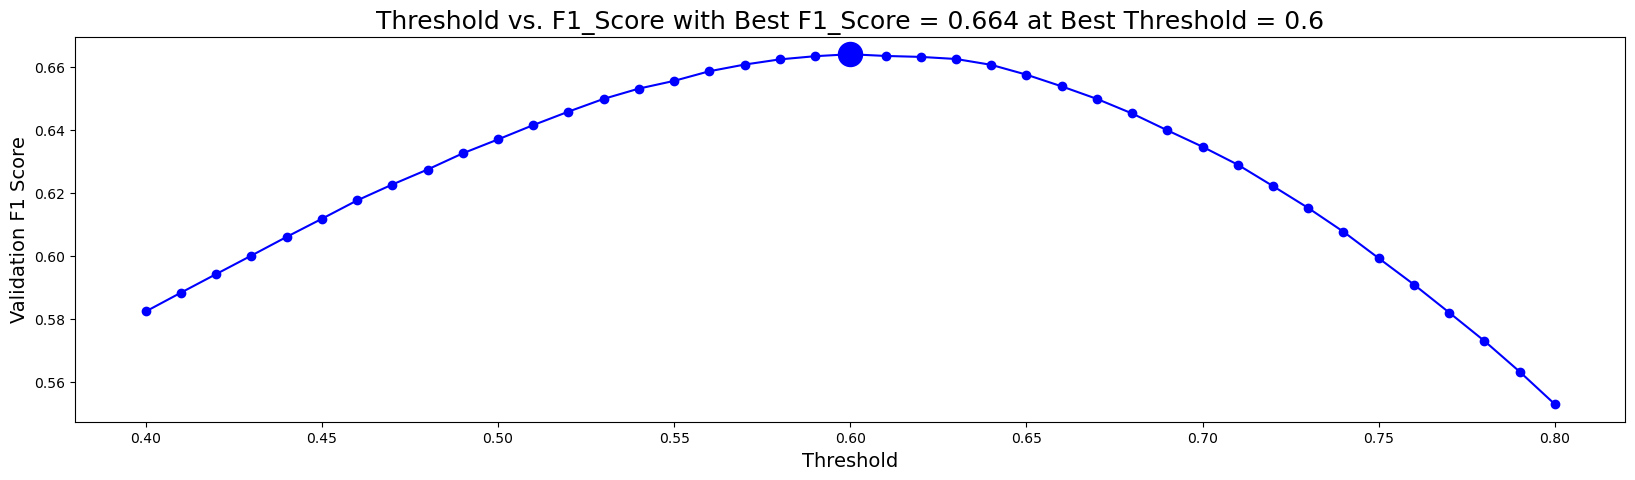

In [22]:
# PLOT THRESHOLD VS. F1_SCORE
plt.figure(figsize=(20,5))
plt.plot(thresholds,scores,'-o',color='blue')
plt.scatter([RFC_best_threshold], [RFC_best_score], color='blue', s=300, alpha=1)
plt.xlabel('Threshold',size=14)
plt.ylabel('Validation F1 Score',size=14)
plt.title(f'Threshold vs. F1_Score with Best F1_Score = {RFC_best_score:.3f} at Best Threshold = {RFC_best_threshold:.3}',size=18)
plt.show()

In [23]:
print('When using optimal threshold...')
for k in range(18):
        
    # COMPUTE F1 SCORE PER QUESTION
    m = f1_score(true[k].values, (oof[k].values>RFC_best_threshold).astype('int'), average='macro')
    print(f'Q{k}: F1 =',m)
    
# COMPUTE F1 SCORE OVERALL
m = f1_score(true.values.reshape((-1)), (oof.values.reshape((-1))>RFC_best_threshold).astype('int'), average='macro')
print('==> Overall F1 =',m)

When using optimal threshold...
Q0: F1 = 0.5463393359756475
Q1: F1 = 0.4946370344945941
Q2: F1 = 0.4857862280792049
Q3: F1 = 0.577195045830209
Q4: F1 = 0.5536354216504751
Q5: F1 = 0.5841241186949655
Q6: F1 = 0.5754395651213465
Q7: F1 = 0.5317600118888457
Q8: F1 = 0.5820965934117546
Q9: F1 = 0.5198927702424476
Q10: F1 = 0.5679702454401679
Q11: F1 = 0.49486268843719616
Q12: F1 = 0.4387229643142237
Q13: F1 = 0.5864289999198457
Q14: F1 = 0.4977772608845867
Q15: F1 = 0.4842142943425777
Q16: F1 = 0.5276855409504827
Q17: F1 = 0.4922787040474011
==> Overall F1 = 0.6640958639103067


Random forest model gets a F1_score = 0.663

# <a name="C33"> P3.3 : XGBoost </a>

Better model is given here : https://www.kaggle.com/code/cdeotte/xgboost-baseline-0-676/notebook?scriptVersionId=118599734

In [24]:
oof = pd.DataFrame(data=np.zeros((len(ALL_USERS),18)), index=ALL_USERS)
XGB_models = {}

# COMPUTE CV SCORE WITH 5 GROUP K FOLD
for i, (train_index, test_index) in enumerate(gkf.split(X=df, groups=df.index)):
    print('#'*25)
    print('### Fold',i+1)
    print('#'*25)
    
    # ITERATE THRU QUESTIONS 1 THRU 18
    for t in range(1,19):
        print(t,', ',end='')
        
        # USE THIS TRAIN DATA WITH THESE QUESTIONS
        if t<=3: grp = '0-4'
        elif t<=13: grp = '5-12'
        elif t<=22: grp = '13-22'
            
        # TRAIN DATA
        train_x = df.iloc[train_index]
        train_x = train_x.loc[train_x.level_group == grp]
        train_users = train_x.index.values
        train_y = targets.loc[targets.q==t].set_index('session').loc[train_users]
        
        # VALID DATA
        valid_x = df.iloc[test_index]
        valid_x = valid_x.loc[valid_x.level_group == grp]
        valid_users = valid_x.index.values
        valid_y = targets.loc[targets.q==t].set_index('session').loc[valid_users]
        
        # TRAIN MODEL
        clf = XGBClassifier()
        clf.fit(train_x[FEATURES].astype('float32'), train_y['correct'])
        
        # SAVE MODEL, PREDICT VALID OOF
        XGB_models[f'{grp}_{t}'] = clf
        oof.loc[valid_users, t-1] = clf.predict_proba(valid_x[FEATURES].astype('float32'))[:,1]
    print()

#########################
### Fold 1
#########################
1 , 2 , 3 , 4 , 5 , 6 , 7 , 8 , 9 , 10 , 11 , 12 , 13 , 14 , 15 , 16 , 17 , 18 , 
#########################
### Fold 2
#########################
1 , 2 , 3 , 4 , 5 , 6 , 7 , 8 , 9 , 10 , 11 , 12 , 13 , 14 , 15 , 16 , 17 , 18 , 
#########################
### Fold 3
#########################
1 , 2 , 3 , 4 , 5 , 6 , 7 , 8 , 9 , 10 , 11 , 12 , 13 , 14 , 15 , 16 , 17 , 18 , 
#########################
### Fold 4
#########################
1 , 2 , 3 , 4 , 5 , 6 , 7 , 8 , 9 , 10 , 11 , 12 , 13 , 14 , 15 , 16 , 17 , 18 , 
#########################
### Fold 5
#########################
1 , 2 , 3 , 4 , 5 , 6 , 7 , 8 , 9 , 10 , 11 , 12 , 13 , 14 , 15 , 16 , 17 , 18 , 


In [25]:
# FIND BEST THRESHOLD TO CONVERT PROBS INTO 1s AND 0s
scores = []; thresholds = []
XGB_best_score = 0; XGB_best_threshold = 0

for threshold in np.arange(0.4,0.81,0.01):
    print(f'{threshold:.02f}, ',end='')
    preds = (oof.values.reshape((-1))>threshold).astype('int')
    m = f1_score(true.values.reshape((-1)), preds, average='macro')   
    scores.append(m)
    thresholds.append(threshold)
    if m>XGB_best_score:
        XGB_best_score = m
        XGB_best_threshold = threshold
        
print('\n' ,'Best_score:', XGB_best_score, '\n','Best_threshold:', XGB_best_threshold)

0.40, 0.41, 0.42, 0.43, 0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.50, 0.51, 0.52, 0.53, 0.54, 0.55, 0.56, 0.57, 0.58, 0.59, 0.60, 0.61, 0.62, 0.63, 0.64, 0.65, 0.66, 0.67, 0.68, 0.69, 0.70, 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77, 0.78, 0.79, 0.80, 
 Best_score: 0.6472542892873047 
 Best_threshold: 0.6300000000000002


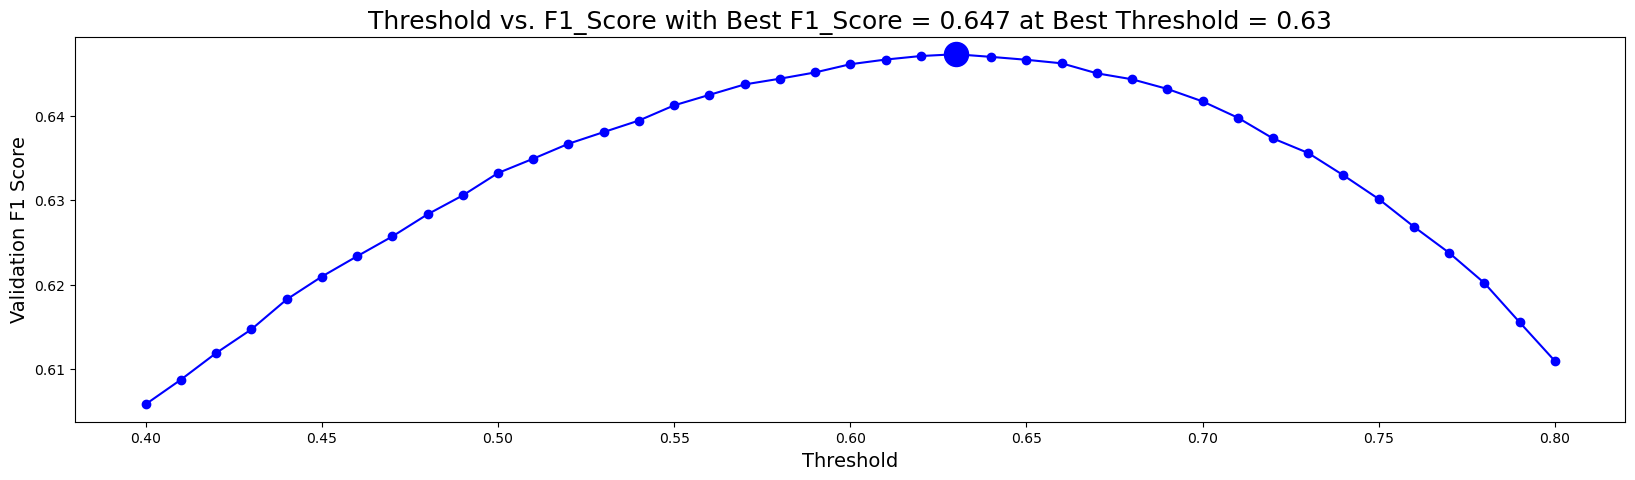

In [26]:
# PLOT THRESHOLD VS. F1_SCORE
plt.figure(figsize=(20,5))
plt.plot(thresholds,scores,'-o',color='blue')
plt.scatter([XGB_best_threshold], [XGB_best_score], color='blue', s=300, alpha=1)
plt.xlabel('Threshold',size=14)
plt.ylabel('Validation F1 Score',size=14)
plt.title(f'Threshold vs. F1_Score with Best F1_Score = {XGB_best_score:.3f} at Best Threshold = {XGB_best_threshold:.3}',size=18)
plt.show()

In [27]:
print('When using optimal threshold...')
for k in range(18):
        
    # COMPUTE F1 SCORE PER QUESTION
    m = f1_score(true[k].values, (oof[k].values>XGB_best_threshold).astype('int'), average='macro')
    print(f'Q{k}: F1 =',m)
    
# COMPUTE F1 SCORE OVERALL
m = f1_score(true.values.reshape((-1)), (oof.values.reshape((-1))>XGB_best_threshold).astype('int'), average='macro')
print('==> Overall F1 =',m)

When using optimal threshold...
Q0: F1 = 0.5468108064082206
Q1: F1 = 0.49457198026174637
Q2: F1 = 0.4963531226447184
Q3: F1 = 0.5791796237430392
Q4: F1 = 0.5559791180342896
Q5: F1 = 0.5743322196703065
Q6: F1 = 0.562700619626005
Q7: F1 = 0.5220396279956865
Q8: F1 = 0.5718312725481106
Q9: F1 = 0.5330269237559896
Q10: F1 = 0.5451821827998226
Q11: F1 = 0.5019747427323646
Q12: F1 = 0.4810733329383616
Q13: F1 = 0.567848162049475
Q14: F1 = 0.5398870266062188
Q15: F1 = 0.5115179454635223
Q16: F1 = 0.5244977567053538
Q17: F1 = 0.5057272876850891
==> Overall F1 = 0.6472542892873047


XGBoost model gets a F1_score = 0.647

# <a name="C34"> P3.4 : Keras </a>

This model is created by : https://www.kaggle.com/code/amaanansari09/neural-network-keras-for-jo-wilder-competition

In [28]:
oof = pd.DataFrame(data=np.zeros((len(ALL_USERS),18)), index=ALL_USERS)
keras_models = {}

# COMPUTE CV SCORE WITH 5 GROUP K FOLD
for i, (train_index, test_index) in enumerate(gkf.split(X=df, groups=df.index)):
    print('#'*25)
    print('### Fold',i+1)
    print('#'*25)
    
    # ITERATE THRU QUESTIONS 1 THRU 18
    for t in range(1,19):
        print(t,', ',end='')
        
        # USE THIS TRAIN DATA WITH THESE QUESTIONS
        if t<=3: grp = '0-4'
        elif t<=13: grp = '5-12'
        elif t<=22: grp = '13-22'
            
        # TRAIN DATA
        train_x = df.iloc[train_index]
        train_x = train_x.loc[train_x.level_group == grp]
        train_users = train_x.index.values
        train_y = targets.loc[targets.q==t].set_index('session').loc[train_users]
        train_y['uncorrect'] = (1-train_y['correct']).abs()
        
        # VALID DATA
        valid_x = df.iloc[test_index]
        valid_x = valid_x.loc[valid_x.level_group == grp]
        valid_users = valid_x.index.values
        valid_y = targets.loc[targets.q==t].set_index('session').loc[valid_users]
        
        # CLEARING Backend before every NN
        keras.backend.clear_session()        
        
        clf = keras.models.Sequential([
                    keras.layers.Dense(32, activation="elu"),
                    keras.layers.Dropout(0.5),
                    keras.layers.Dense(16, activation="elu"),
                    keras.layers.Dropout(0.25),
                    keras.layers.Dense(1, activation="sigmoid")
                ])

        clf.compile(loss='binary_crossentropy',
                    optimizer=keras.optimizers.Nadam(learning_rate=0.05), 
                    metrics=['accuracy']
                    )

        history = clf.fit(train_x[FEATURES].astype('float32'), train_y['correct'], epochs=10, verbose = 0)
        
        # SAVE MODEL, PREDICT VALID OOF
        keras_models[f'{grp}_{t}'] = clf
        keras_p = clf.predict(valid_x[FEATURES].astype('float32'))
        new_arr = np.hstack((np.zeros(keras_p.shape), keras_p))
        oof.loc[valid_users, t-1] = new_arr[:,1]    
    print()

#########################
### Fold 1
#########################
74/74 [==============================] - 0s 828us/step

#########################
### Fold 2
#########################
74/74 [==============================] - 0s 804us/step

#########################
### Fold 3
#########################
74/74 [==============================] - 0s 953us/step

#########################
### Fold 4
#########################
74/74 [==============================] - 0s 781us/step

#########################
### Fold 5
#########################
74/74 [==============================] - 0s 902us/step



In [29]:
# FIND BEST THRESHOLD TO CONVERT PROBS INTO 1s AND 0s
scores = []; thresholds = []
keras_best_score = 0; keras_best_threshold = 0

for threshold in np.arange(0.4,0.81,0.01):
    print(f'{threshold:.02f}, ',end='')
    preds = (oof.values.reshape((-1))>threshold).astype('int')
    m = f1_score(true.values.reshape((-1)), preds, average='macro')   
    scores.append(m)
    thresholds.append(threshold)
    if m>keras_best_score:
        keras_best_score = m
        keras_best_threshold = threshold
        
print('\n' ,'Best_score:', keras_best_score, '\n','Best_threshold:', keras_best_threshold)

0.40, 0.41, 0.42, 0.43, 0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.50, 0.51, 0.52, 0.53, 0.54, 0.55, 0.56, 0.57, 0.58, 0.59, 0.60, 0.61, 0.62, 0.63, 0.64, 0.65, 0.66, 0.67, 0.68, 0.69, 0.70, 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77, 0.78, 0.79, 0.80, 
 Best_score: 0.6498214976373262 
 Best_threshold: 0.6700000000000003


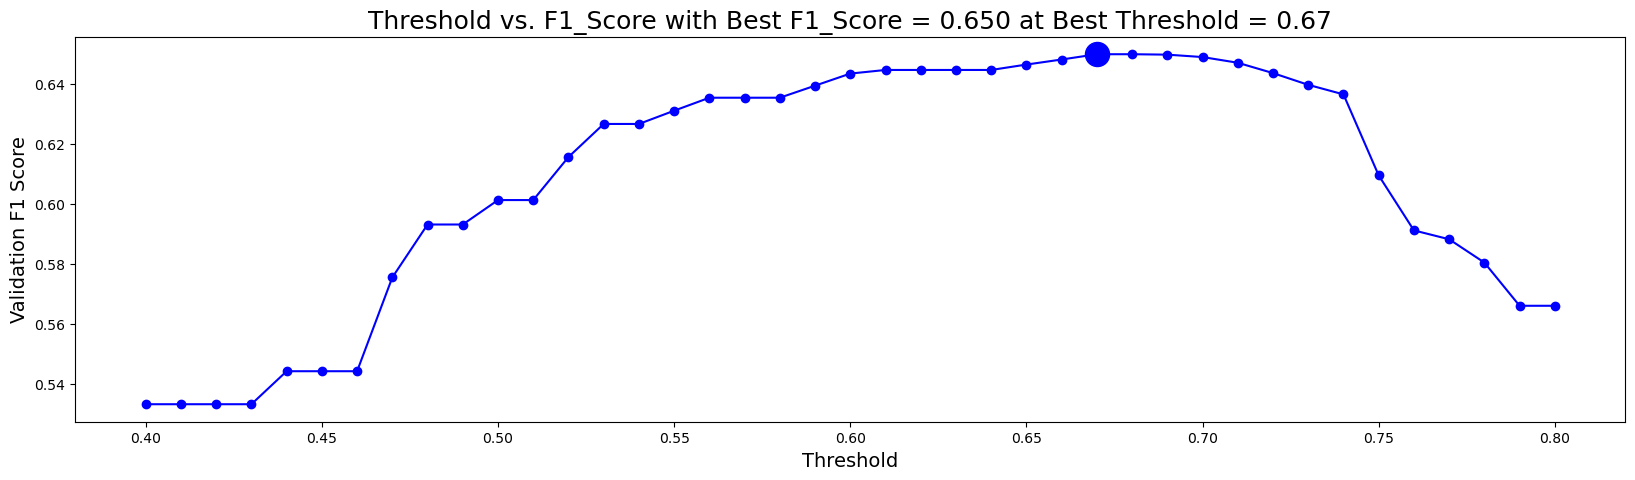

In [30]:
# PLOT THRESHOLD VS. F1_SCORE
plt.figure(figsize=(20,5))
plt.plot(thresholds,scores,'-o',color='blue')
plt.scatter([keras_best_threshold], [keras_best_score], color='blue', s=300, alpha=1)
plt.xlabel('Threshold',size=14)
plt.ylabel('Validation F1 Score',size=14)
plt.title(f'Threshold vs. F1_Score with Best F1_Score = {keras_best_score:.3f} at Best Threshold = {keras_best_threshold:.3}',size=18)
plt.show()

In [31]:
print('When using optimal threshold...')
for k in range(18):
        
    # COMPUTE F1 SCORE PER QUESTION
    m = f1_score(true[k].values, (oof[k].values>keras_best_threshold).astype('int'), average='macro')
    print(f'Q{k}: F1 =',m)
    
# COMPUTE F1 SCORE OVERALL
m = f1_score(true.values.reshape((-1)), (oof.values.reshape((-1))>keras_best_threshold).astype('int'), average='macro')
print('==> Overall F1 =',m)

When using optimal threshold...
Q0: F1 = 0.41995371054316244
Q1: F1 = 0.4946370344945941
Q2: F1 = 0.4824465046794674
Q3: F1 = 0.4442294989147872
Q4: F1 = 0.3120546665109217
Q5: F1 = 0.4356824605950271
Q6: F1 = 0.42171927929697084
Q7: F1 = 0.27833598823673567
Q8: F1 = 0.42378436552196463
Q9: F1 = 0.3333142107479711
Q10: F1 = 0.4978466549639501
Q11: F1 = 0.4616298733945793
Q12: F1 = 0.4217760541946885
Q13: F1 = 0.4152310976517897
Q14: F1 = 0.3408136997033969
Q15: F1 = 0.4245444330450926
Q16: F1 = 0.4066293889476601
Q17: F1 = 0.48733461002785516
==> Overall F1 = 0.6498214976373262


Neural Network model gets a F1_score = 0.65

# <a name="C35"> P3.5 : Final model (optimization) </a>

In [17]:
gkf = GroupKFold(n_splits=5)
oof = pd.DataFrame(data=np.zeros((len(ALL_USERS),18)), index=ALL_USERS)
final_models = {}

# COMPUTE CV SCORE WITH 5 GROUP K FOLD
for i, (train_index, test_index) in enumerate(gkf.split(X=df, groups=df.index)):
    print('#'*25)
    print('### Fold',i+1)
    print('#'*25)
    
    # ITERATE THRU QUESTIONS 1 THRU 18
    for t in range(1,19):
        print(t,', ',end='')
        
        # USE THIS TRAIN DATA WITH THESE QUESTIONS
        if t<=3: grp = '0-4'
        elif t<=13: grp = '5-12'
        elif t<=22: grp = '13-22'
            
        # TRAIN DATA
        train_x = df.iloc[train_index]
        train_x = train_x.loc[train_x.level_group == grp]
        train_users = train_x.index.values
        train_y = targets.loc[targets.q==t].set_index('session').loc[train_users]
        
        # VALID DATA
        valid_x = df.iloc[test_index]
        valid_x = valid_x.loc[valid_x.level_group == grp]
        valid_users = valid_x.index.values
        valid_y = targets.loc[targets.q==t].set_index('session').loc[valid_users]
        
        # Grid Search
        
        clf = RandomForestClassifier(n_estimators=1000, 
                                     max_depth=4)
        clf.fit(train_x[FEATURES].astype('float32'), train_y['correct'])
        
        # SAVE MODEL, PREDICT VALID OOF
        final_models[f'{grp}_{t}'] = clf
        oof.loc[valid_users, t-1] = clf.predict_proba(valid_x[FEATURES].astype('float32'))[:,1]
    print()

#########################
### Fold 1
#########################
1 , 2 , 3 , 4 , 5 , 6 , 7 , 8 , 9 , 10 , 11 , 12 , 13 , 14 , 15 , 16 , 17 , 18 , 
#########################
### Fold 2
#########################
1 , 2 , 3 , 4 , 5 , 6 , 7 , 8 , 9 , 10 , 11 , 12 , 13 , 14 , 15 , 16 , 17 , 18 , 
#########################
### Fold 3
#########################
1 , 2 , 3 , 4 , 5 , 6 , 7 , 8 , 9 , 10 , 11 , 12 , 13 , 14 , 15 , 16 , 17 , 18 , 
#########################
### Fold 4
#########################
1 , 2 , 3 , 4 , 5 , 6 , 7 , 8 , 9 , 10 , 11 , 12 , 13 , 14 , 15 , 16 , 17 , 18 , 
#########################
### Fold 5
#########################
1 , 2 , 3 , 4 , 5 , 6 , 7 , 8 , 9 , 10 , 11 , 12 , 13 , 14 , 15 , 16 , 17 , 18 , 


In [22]:
# FIND BEST THRESHOLD TO CONVERT PROBS INTO 1s AND 0s
scores = []; thresholds = []
final_best_score = 0; final_best_threshold = 0

for threshold in np.arange(0.4,0.81,0.01):
    print(f'{threshold:.02f}, ',end='')
    preds = (oof.values.reshape((-1))>threshold).astype('int')
    m = f1_score(true.values.reshape((-1)), preds, average='macro')   
    scores.append(m)
    thresholds.append(threshold)
    if m>final_best_score:
        final_best_score = m
        final_best_threshold = threshold
        
print('\n' ,'Best_score:', final_best_score, '\n','Best_threshold:', final_best_threshold)

0.40, 0.41, 0.42, 0.43, 0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.50, 0.51, 0.52, 0.53, 0.54, 0.55, 0.56, 0.57, 0.58, 0.59, 0.60, 0.61, 0.62, 0.63, 0.64, 0.65, 0.66, 0.67, 0.68, 0.69, 0.70, 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77, 0.78, 0.79, 0.80, 
 Best_score: 0.6689836090771094 
 Best_threshold: 0.6400000000000002


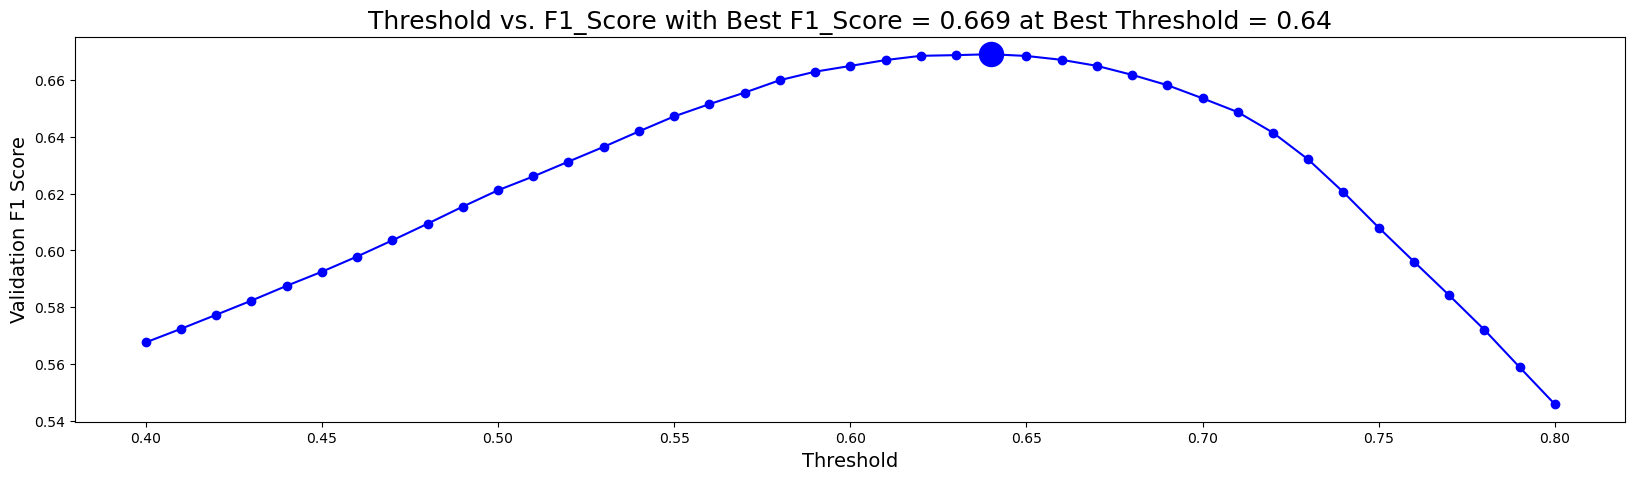

In [23]:
# PLOT THRESHOLD VS. F1_SCORE
plt.figure(figsize=(20,5))
plt.plot(thresholds,scores,'-o',color='blue')
plt.scatter([final_best_threshold], [final_best_score], color='blue', s=300, alpha=1)
plt.xlabel('Threshold',size=14)
plt.ylabel('Validation F1 Score',size=14)
plt.title(f'Threshold vs. F1_Score with Best F1_Score = {final_best_score:.3f} at Best Threshold = {final_best_threshold:.3}',size=18)
plt.show()

In [24]:
print('When using optimal threshold...')
for k in range(18):
        
    # COMPUTE F1 SCORE PER QUESTION
    m = f1_score(true[k].values, (oof[k].values>final_best_threshold).astype('int'), average='macro')
    print(f'Q{k}: F1 =',m)
    
# COMPUTE F1 SCORE OVERALL
m = f1_score(true.values.reshape((-1)), (oof.values.reshape((-1))>final_best_threshold).astype('int'), average='macro')
print('==> Overall F1 =',m)

When using optimal threshold...
Q0: F1 = 0.502702611513477
Q1: F1 = 0.4946370344945941
Q2: F1 = 0.4824465046794674
Q3: F1 = 0.5286790793052227
Q4: F1 = 0.46032090725923713
Q5: F1 = 0.5685139559952153
Q6: F1 = 0.5549336943415133
Q7: F1 = 0.5163734235202233
Q8: F1 = 0.573330787727645
Q9: F1 = 0.35062027252061145
Q10: F1 = 0.5807375316709422
Q11: F1 = 0.46214635234359946
Q12: F1 = 0.4218044374631848
Q13: F1 = 0.5834489321101807
Q14: F1 = 0.3408136997033969
Q15: F1 = 0.4259776967477438
Q16: F1 = 0.5315076235777507
Q17: F1 = 0.48733461002785516
==> Overall F1 = 0.6689836090771094


Final model gets F1_score = 0.669

# Part 4: Submission

# <a name="C41"> P4.1 : Submission </a>

In [25]:
env = jo_wilder.make_env()
iter_test = env.iter_test()

In [26]:
limits = {'0-4':(1,4), '5-12':(4,14), '13-22':(14,19)}
models = final_models
best_threshold = final_best_threshold

for (sample_submission, test) in iter_test:
    
    df = feature_engineer(test)
    grp = test.level_group.values[0]
    a,b = limits[grp]
    for t in range(a,b):
        clf = models[f'{grp}_{t}']
        p = clf.predict_proba(df[FEATURES].astype('float32'))[:,1]
        mask = sample_submission.session_id.str.contains(f'q{t}')
        sample_submission.loc[mask,'correct'] = int(p.item()>best_threshold)
    
    env.predict(sample_submission)

This version of the API is not optimized and should not be used to estimate the runtime of your code on the hidden test set.


In [27]:
submission_df = pd.read_csv('submission.csv')
print( submission_df.shape )
submission_df.head()

(54, 2)


,session_id,correct
0,20090109393214576_q1,1
1,20090109393214576_q2,1
2,20090109393214576_q3,1
3,20090312143683264_q1,1
4,20090312143683264_q2,1


Submission file